In [87]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tqdm import trange

### Parametros a Usar

In [36]:
parametros_variables=0.67,0.022,0.14,0.97 #h,w_b,w_m,ns
h,w_b,w_m,ns=parametros_variables

h=0.6727
parametros_planck=h,0.02212,0.1434,0.9626 #h,w_b,w_m,ns
h,w_b,w_m,ns=parametros_planck

z_dec=1090
N_eff=3046
w_gamma=2.47*10**(-5)
#w_r=(1+7/8*N_eff*(4/11)**(4/3))*w_gamma
w_r=4.17*10**(-5)
w_lamb=h**2-w_m-w_r
A_s=2.2*10**(-9)
k_0=0.05
H_0=h/2998

###  Funciones a Usar

In [65]:
def R(z):
    return w_b*(3.04*10**4)/(1+z)
    
def c_s(z):
    c=(1/3)*(1+R(z))
    return np.sqrt(c)
    
def T(x):
    parte1=np.log(1+0.171*x)/(0.171*x)
    parte2=(1 + 0.284*x + np.power(1.18*x,2) + np.power(0.399*x,3) + np.power(0.49*x,4))**(-0.25)
    return parte1*parte2
    
def E_inv(z):
    parte1=w_m*np.power((1+z),3) + w_r*np.power((1+z),4) + w_lamb
    #parte1=w_m*((1+z)**3) + w_r*((1+z)**4)+w_lamb
    return (np.sqrt(parte1)/h)**(-1)
    
def P_R(k):
    return A_s*(k/k_0)**(ns-1)
    
def func_int_rs(z):
    return c_s(z)*E_inv(z)

def func_bessel(x,l):
    if x>l:
        return 0.5/(x*np.sqrt(np.power(x,2)-np.power(l,2)))
    else:
        return 0    
#def func_bessel(x,l):
#    mascara=x>l
#    vector=np.zeros(x.shape[0])
#    vector[mascara]=0.5/(x[mascara]*np.sqrt(np.power(x[mascara],2)-np.power(l,2)))
#    return vector

### Sacar los valores de $R(z_{dec}), d_A^c$ y $r_s$



In [68]:
d_A = integrate.quad(E_inv,0.001,z_dec)[0]/H_0
r_s=integrate.quad(func_int_rs,z_dec,10**6)[0]/H_0
k_eq=0.073*w_m
k_d=0.14
print("R(Z_dec)={:.5f}, d_A={:.5f} y r_s={:.5f}".format(R(z_dec),d_A,r_s))

R(Z_dec)=0.61636, d_A=13853.87682 y r_s=181.80104


### Sacar el espectro angular de temperaturas del CMB

In [95]:
def c_l_funcion(l,R_z,d_A,r_s):
    def func_int(k):
        const=4*np.pi*9/25
        parte1=P_R(k)
        parte2=np.power(-R_z*T(k/k_eq)+5/3*np.cos(k*r_s)*np.exp(-(k/k_d)**2),2)
        parte3=func_bessel(k*d_A,l)/k
        return parte1*parte2*parte3

    #limite_sup=np.inf
    limite_sup=3000/(d_A)
    #limite_inf=0
    limite_inf=l/(d_A)
    resultado=integrate.quad(func_int,limite_inf,limite_sup)[0]
    #resultado=integrate.romberg(func_int,limite_inf,limite_sup)[0]
    return resultado
    
l_minimo=100
l_maximo=1501
l_array=np.array(range(l_minimo,l_maximo))
longitud=len(l_array)
cl=np.zeros(longitud)
i=0    
for l in l_array:
    valor=c_l_funcion(l,R(z_dec),d_A,r_s)
    constante=4*np.pi*9/25
    cl[i]=constante*valor*l*(l+1)/(2*np.pi)
    i+=1

### Gráfica

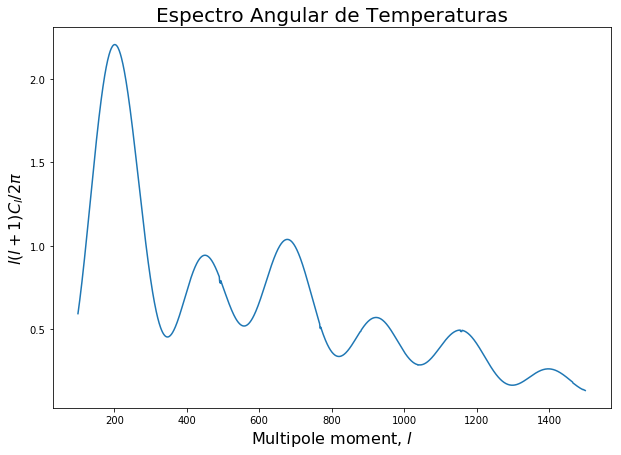

In [96]:
plt.figure(figsize=(10,7))
plt.title("Espectro Angular de Temperaturas", fontsize=20)
plt.ylabel("$l(l+1)C_l/2\pi$", fontsize=16)
plt.xlabel("Multipole moment, $l$", fontsize=16)
plt.plot(l_array,cl*10**9)
plt.savefig("Espec.png")
plt.show()        

### Variación de los parámetros
Empezamos variando $R(z_{dec})$

In [97]:
paso=5
variacion=np.linspace(0.1,2,paso)

plt.figure(figsize=(10,7))

for j in trange(paso):
    sig=variacion[j]
    l_minimo=100
    l_maximo=1501
    l_array=np.array(range(l_minimo,l_maximo))
    longitud=len(l_array)
    cl=np.zeros(longitud)
    i=0    
    for l in l_array:
        valor=c_l_funcion(l,R(z_dec)*sig,d_A,r_s)
        constante=4*np.pi*9/25
        cl[i]=constante*valor*l*(l+1)/(2*np.pi)
        i+=1
    
    plt.plot(l_array,cl*10**9,label="$R_z=R(z_d)*{:.2f}$".format(sig))

plt.title("Espectro Angular de Temperaturas, Variacion en $R(z_{dec})$", fontsize=20)
plt.ylabel("$l(l+1)C_l/2\pi$", fontsize=16)
plt.xlabel("Multipole moment, $l$", fontsize=16)
plt.legend()
plt.savefig("Espec_R_z.png")
plt.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.07s/it]


Calculamos las variaciones para $d_A$

In [98]:
paso=5
variacion=np.linspace(0.1,2,paso)

plt.figure(figsize=(10,7))

for j in trange(paso):
    sig=variacion[j]
    l_minimo=100
    l_maximo=1501
    l_array=np.array(range(l_minimo,l_maximo))
    longitud=len(l_array)
    cl=np.zeros(longitud)
    i=0    
    for l in l_array:
        valor=c_l_funcion(l,R(z_dec),d_A*sig,r_s)
        constante=4*np.pi*9/25
        cl[i]=constante*valor*l*(l+1)/(2*np.pi)
        i+=1
    
    plt.plot(l_array,cl*10**9,label="$d=d_A*{:.2f}$".format(sig))

plt.title("Espectro Angular de Temperaturas, Variacion en $d_A$", fontsize=20)
plt.ylabel("$l(l+1)C_l/2\pi$", fontsize=16)
plt.xlabel("Multipole moment, $l$", fontsize=16)
plt.legend()
plt.savefig("Espec_d_a.png")
plt.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.95s/it]


Calculamos las variaciones para $r_s$

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.16s/it]


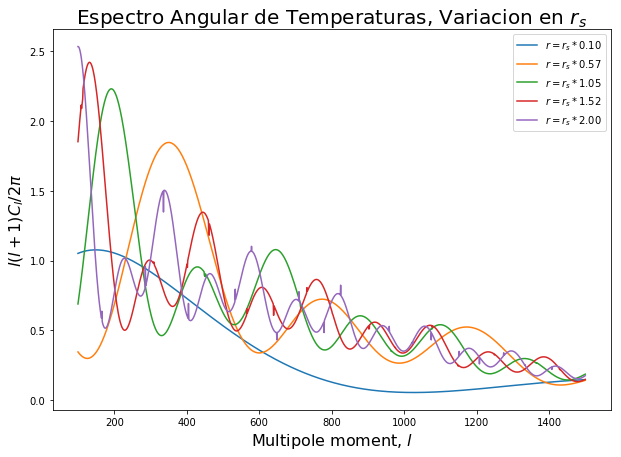

In [99]:
paso=5
variacion=np.linspace(0.1,2,paso)

plt.figure(figsize=(10,7))

for j in trange(paso):
    sig=variacion[j]
    l_minimo=100
    l_maximo=1501
    l_array=np.array(range(l_minimo,l_maximo))
    longitud=len(l_array)
    cl=np.zeros(longitud)
    i=0    
    for l in l_array:
        valor=c_l_funcion(l,R(z_dec),d_A,r_s*sig)
        constante=4*np.pi*9/25
        cl[i]=constante*valor*l*(l+1)/(2*np.pi)
        i+=1
    
    plt.plot(l_array,cl*10**9,label="$r=r_s*{:.2f}$".format(sig))

plt.title("Espectro Angular de Temperaturas, Variacion en $r_s$", fontsize=20)
plt.ylabel("$l(l+1)C_l/2\pi$", fontsize=16)
plt.xlabel("Multipole moment, $l$", fontsize=16)
plt.legend()
plt.show()
plt.savefig("Espec_r_s.png")
plt.close()